
# IDS — Dùng **tất cả đặc trưng** (union 4 bộ dữ liệu) với LightGBM

- Bộ dữ liệu: **CICDDoS2017 + CICDDoS2019 (chính)**, kèm **KDD99 & UNSW-NB15**  
- Lấy **toàn bộ đặc trưng có trong 4 bộ** (union cột), tự động encode các cột **categorical**  
- Giữ nguyên pipeline: **split 8/2 → scaler/SMOTE → Phase 1 (binary) → Phase 2 (multiclass)**  
- Model: **LightGBM** (nhanh & chính xác cho tabular)


In [ ]:

import os, glob, warnings, joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 120


In [2]:

CIC2019_DIR = r'D:\DACN\dataset\CICDDoS2019'
CIC2017_DIR = r'D:\DACN\dataset\CICDDoS2017'
KDD99_DIR   = r'D:\DACN\dataset\KDD99'
UNSW15_DIR  = r'D:\DACN\dataset\UNSW-NB15'

# Tuỳ chọn loại bỏ các cột định danh/dấu thời gian (nên bật để tránh rò rỉ)
EXCLUDE_ID_COLUMNS = True
ID_LIKE_COLS = set([
    'Flow ID','FlowID','Timestamp','StartTime','Start Time','stime','time','Date','datetime',
    'Src IP','Dst IP','Source IP','Destination IP',
    'srcip','dstip','srcip_addr','dstip_addr',
    'Src Port','Dst Port','Sport','Dport','srcport','dstport',
    'ProtocolName','ProtoName','Service','service','state','attack_cat','label',
    'Unnamed: 0','id','No.','Index'
])


In [3]:

LABEL_CANDS = ["Label","label","Attack","attack","attack_cat","class","Class","target","category","Category","result"]

def detect_label_col(df: pd.DataFrame):
    for c in LABEL_CANDS:
        if c in df.columns: return c
    raise ValueError("Không tìm thấy cột nhãn trong dataframe.")

def safe_read_any(path: str) -> pd.DataFrame:
    try:
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        elif path.lower().endswith(".csv"):
            for enc in ("utf-8-sig","utf-8","cp1252","latin1"):
                try:
                    return pd.read_csv(path, encoding=enc)
                except Exception:
                    continue
            return pd.read_csv(path)
        else:
            return pd.DataFrame()
    except Exception as e:
        print(f"[WARN] skip {path}: {e}")
        return pd.DataFrame()

def load_dir_parquet_csv(root: str, pattern=("*.parquet","*.csv")) -> list:
    if not os.path.isdir(root): return []
    files = []
    for p in pattern:
        files += glob.glob(os.path.join(root, "**", p), recursive=True)
    out = []
    for f in tqdm(files, desc=f"Đọc {os.path.basename(root)}"):
        df = safe_read_any(f)
        if not df.empty:
            out.append(df)
    return out


In [4]:

# ==== Load CIC2019 & CIC2017 ====
df2019_train_paths, df2019_test_paths = [], []
for dirname, _, filenames in os.walk(CIC2019_DIR):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            df2019_train_paths.append(os.path.join(dirname, filename))
        elif filename.endswith('-testing.parquet'):
            df2019_test_paths.append(os.path.join(dirname, filename))

df_2017 = []
for dirname, _, filenames in os.walk(CIC2017_DIR):
    for filename in filenames:
        if filename.endswith('.parquet'):
            df_2017.append(os.path.join(dirname, filename))

df_2017 = pd.concat([pd.read_parquet(p) for p in df_2017], ignore_index=True) if df_2017 else pd.DataFrame()
df_2019 = pd.concat([pd.read_parquet(p) for p in df2019_train_paths], ignore_index=True) if df2019_train_paths else pd.DataFrame()

print("CIC2017:", df_2017.shape, "| CIC2019 train:", df_2019.shape)


CIC2017: (2313810, 78) | CIC2019 train: (125170, 78)


In [5]:

# ==== Load KDD99 & UNSW-NB15 ====
dfs_kdd  = load_dir_parquet_csv(KDD99_DIR)
dfs_unsw = load_dir_parquet_csv(UNSW15_DIR)
df_kdd   = pd.concat(dfs_kdd, ignore_index=True) if dfs_kdd else pd.DataFrame()
df_unsw  = pd.concat(dfs_unsw, ignore_index=True) if dfs_unsw else pd.DataFrame()
print("KDD99:", df_kdd.shape, "| UNSW-NB15:", df_unsw.shape)


KDD99: (0, 0) | UNSW-NB15: (0, 0)


In [6]:

# ==== Chuẩn hoá nhãn (Label, AttackType) ====
def normalize_ext_dataset(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    if df.empty: return df
    try:
        lbl = detect_label_col(df)
        df = df.copy()
        df.rename(columns={lbl: "Label"}, inplace=True)
        df["Label"] = df["Label"].astype(str).str.strip()
        df.loc[df["Label"].str.lower().isin(["normal","benign","non-attack","good"]), "Label"] = "Benign"
        if "AttackType" not in df.columns:
            df["AttackType"] = np.where(df["Label"]=="Benign","Benign","Other")
        return df
    except Exception as e:
        print(f"[WARN] {dataset_name}: không chuẩn hoá được label ({e})")
        return pd.DataFrame()

df_kdd  = normalize_ext_dataset(df_kdd,  "KDD99")
df_unsw = normalize_ext_dataset(df_unsw, "UNSW-NB15")

df_main = pd.concat([df_2017, df_2019], ignore_index=True) if not df_2017.empty or not df_2019.empty else pd.DataFrame()
df_extra = [d for d in (df_kdd, df_unsw) if not d.empty]
df = pd.concat([df_main] + df_extra, ignore_index=True) if df_extra else df_main
assert not df.empty, "Không có dữ liệu sau khi đọc các thư mục!"

# Nếu chưa có AttackType, tạo từ Label
if "AttackType" not in df.columns and "Label" in df.columns:
    df["AttackType"] = df["Label"]

# Map nhóm chi tiết dựa trên 2017/2019, còn lại -> Other
attack_group_map = {
    'DrDoS_DNS':'DrDoS','DrDoS_SNMP':'DrDoS','DrDoS_NTP':'DrDoS','DrDoS_MSSQL':'DrDoS',
    'DrDoS_SSDP':'DrDoS','DrDoS_UDP':'DrDoS','TFTP':'TFTP',
    'UDP':'UDP','UDPLag':'UDP','Syn':'Syn','MSSQL':'MSSQL','LDAP':'LDAP',
    'DoS slowloris':'DoS','DoS Slowhttptest':'DoS','DoS Hulk':'DoS','DoS GoldenEye':'DoS',
    'Heartbleed':'Other',
    'Web Attack � Brute Force':'Web Attack','Web Attack � XSS':'Web Attack','Web Attack � Sql Injection':'Web Attack',
    'FTP-Patator':'Brute Force','SSH-Patator':'Brute Force','Infiltration':'Other','Bot':'Other',
    'PortScan':'PortScan','NetBIOS':'Other'
}
def group_attack_type(x):
    if pd.isna(x): return 'Other'
    if x == 'Benign': return 'Benign'
    return attack_group_map.get(str(x), 'Other')

df["AttackType"] = df["AttackType"].apply(group_attack_type)
df["Label"] = df["Label"].apply(lambda v: 'Benign' if str(v)=='Benign' else 'DDoS')
print("Label uniq:", df["Label"].unique())
print("AttackType uniq:", df["AttackType"].unique())


Label uniq: ['Benign' 'DDoS']
AttackType uniq: ['Benign' 'Other' 'Brute Force' 'DoS' 'PortScan' 'Web Attack' 'LDAP'
 'MSSQL' 'Syn' 'UDP']



## Tạo **union features** từ 4 bộ dữ liệu
- Lấy **tất cả cột** trừ nhãn (`Label`, `AttackType`) và (tuỳ chọn) các **cột định danh/thời gian**  
- Cột **numeric**: giữ nguyên  
- Cột **categorical** (object/bool/category): **label-encode** (fit trên **train** để tránh leakage)


In [7]:

# ==== Xác định danh sách cột đặc trưng (union) ====
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

all_cols = list(df.columns)
drop_cols = {'Label','AttackType'}
if EXCLUDE_ID_COLUMNS:
    drop_cols |= {c for c in all_cols if c in ID_LIKE_COLS}

feature_candidates = [c for c in all_cols if c not in drop_cols]
print("Tổng cột candidate:", len(feature_candidates))

# Phân loại kiểu cột
num_cols = [c for c in feature_candidates if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in feature_candidates if c not in num_cols]  # object/bool/category
print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))


Tổng cột candidate: 77
Numeric: 77 | Categorical: 0


In [ ]:

y_bin  = (df['Label'] != 'Benign').astype(int).values

X_raw = df[feature_candidates].copy()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)
print("Train raw:", X_train_raw.shape, "| Test raw:", X_test_raw.shape)


Train raw: (1951184, 77) | Test raw: (487796, 77)


In [ ]:

# ==== Encode categorical FIT TRÊN TRAIN, sau đó transform TEST ====
# Map dict: col -> {category: code}
encoders = {}

def encode_categorical_train(df_part: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = df_part.copy()
    for c in cols:
        vals = out[c].astype('category')
        codes = vals.cat.codes  # unseen không tồn tại ở train
        mapping = dict(enumerate(vals.cat.categories))
        # Lưu encoder: category string -> code
        inv_map = {v: k for k, v in mapping.items()}
        encoders[c] = inv_map
        out[c] = codes.astype('int32')
    return out

def encode_categorical_apply(df_part: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = df_part.copy()
    for c in cols:
        if c not in encoders:
            # nếu vì lý do nào đó col categorical không xuất hiện ở train
            out[c] = out[c].astype('category').cat.codes.astype('int32')
            continue
        inv_map = encoders[c]
        # map từng giá trị test -> code; unseen -> -1
        out[c] = out[c].map(lambda v: inv_map.get(v, -1)).astype('int32')
    return out

X_train_enc = X_train_raw.copy()
X_test_enc  = X_test_raw.copy()

# Điền NaN cho cat bằng chuỗi rỗng để đảm bảo map
for c in cat_cols:
    X_train_enc[c] = X_train_enc[c].astype(str).fillna("")
    X_test_enc[c]  = X_test_enc[c].astype(str).fillna("")

X_train_enc = encode_categorical_train(X_train_enc, cat_cols)
X_test_enc  = encode_categorical_apply(X_test_enc, cat_cols)

# Với numeric, thay NaN = 0 (đã fill trước), đảm bảo kiểu float32
for c in num_cols:
    X_train_enc[c] = X_train_enc[c].astype(np.float32)
    X_test_enc[c]  = X_test_enc[c].astype(np.float32)

print("Encoded train:", X_train_enc.shape, "Encoded test:", X_test_enc.shape)


Encoded train: (1951184, 77) Encoded test: (487796, 77)


In [10]:

# ==== Scaler (giữ pipeline cũ) + SMOTE ====
scaler = MinMaxScaler()
scaler.fit(X_train_enc.values)
joblib.dump(scaler, 'scaler_union.pkl')

X_train_s = scaler.transform(X_train_enc.values)
X_test_s  = scaler.transform(X_test_enc.values)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_s, y_train)
print("After SMOTE:", X_res.shape, "| Pos ratio:", y_res.mean().round(4))


After SMOTE: (3237992, 77) | Pos ratio: 0.5


In [13]:

# ==== PHASE 1: LightGBM Binary ====
clf_bin = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=96,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)




In [14]:
clf_bin.fit(
    X_res, y_res,
    eval_set=[(X_test_s, y_test)],
    eval_metric=['auc','binary_logloss'],
    callbacks=[lgb.early_stopping(stopping_rounds=60, verbose=False)]
)

[LightGBM] [Info] Number of positive: 1618996, number of negative: 1618996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.572996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13888
[LightGBM] [Info] Number of data points in the train set: 3237992, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9,
               learning_rate=0.05, n_estimators=1200, n_jobs=-1, num_leaves=96,
               objective='binary', random_state=42, reg_lambda=1.0,
               subsample=0.9)

In [15]:

joblib.dump({'model': clf_bin, 'scaler': scaler, 'encoders': encoders, 'feature_order': X_train_enc.columns.tolist()},
            'lgbm_binary_union.joblib')


['lgbm_binary_union.joblib']

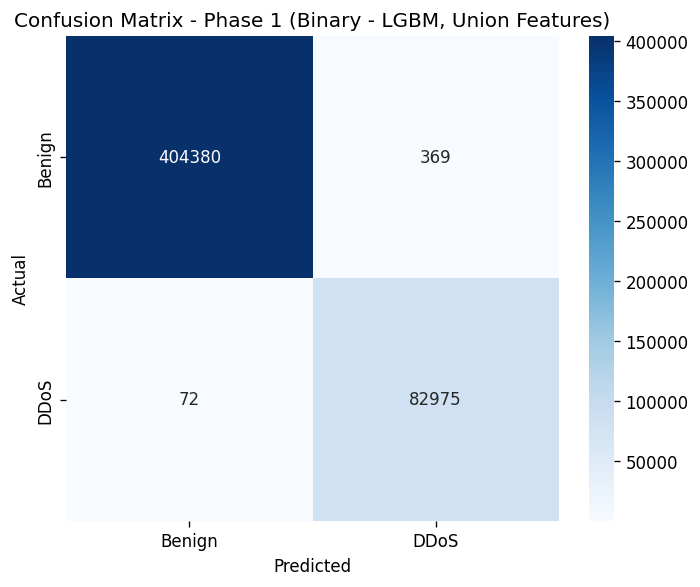

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    404749
        DDoS       1.00      1.00      1.00     83047

    accuracy                           1.00    487796
   macro avg       1.00      1.00      1.00    487796
weighted avg       1.00      1.00      1.00    487796

ROC-AUC: 0.9999893661536485


In [16]:
y_prob = clf_bin.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','DDoS'], yticklabels=['Benign','DDoS'])
plt.title("Confusion Matrix - Phase 1 (Binary - LGBM, Union Features)")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred, target_names=['Benign','DDoS']))
try:
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

Các lớp attack: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13470
[LightGBM] [Info] Number of data points in the train set: 1394964, number of used features: 67
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

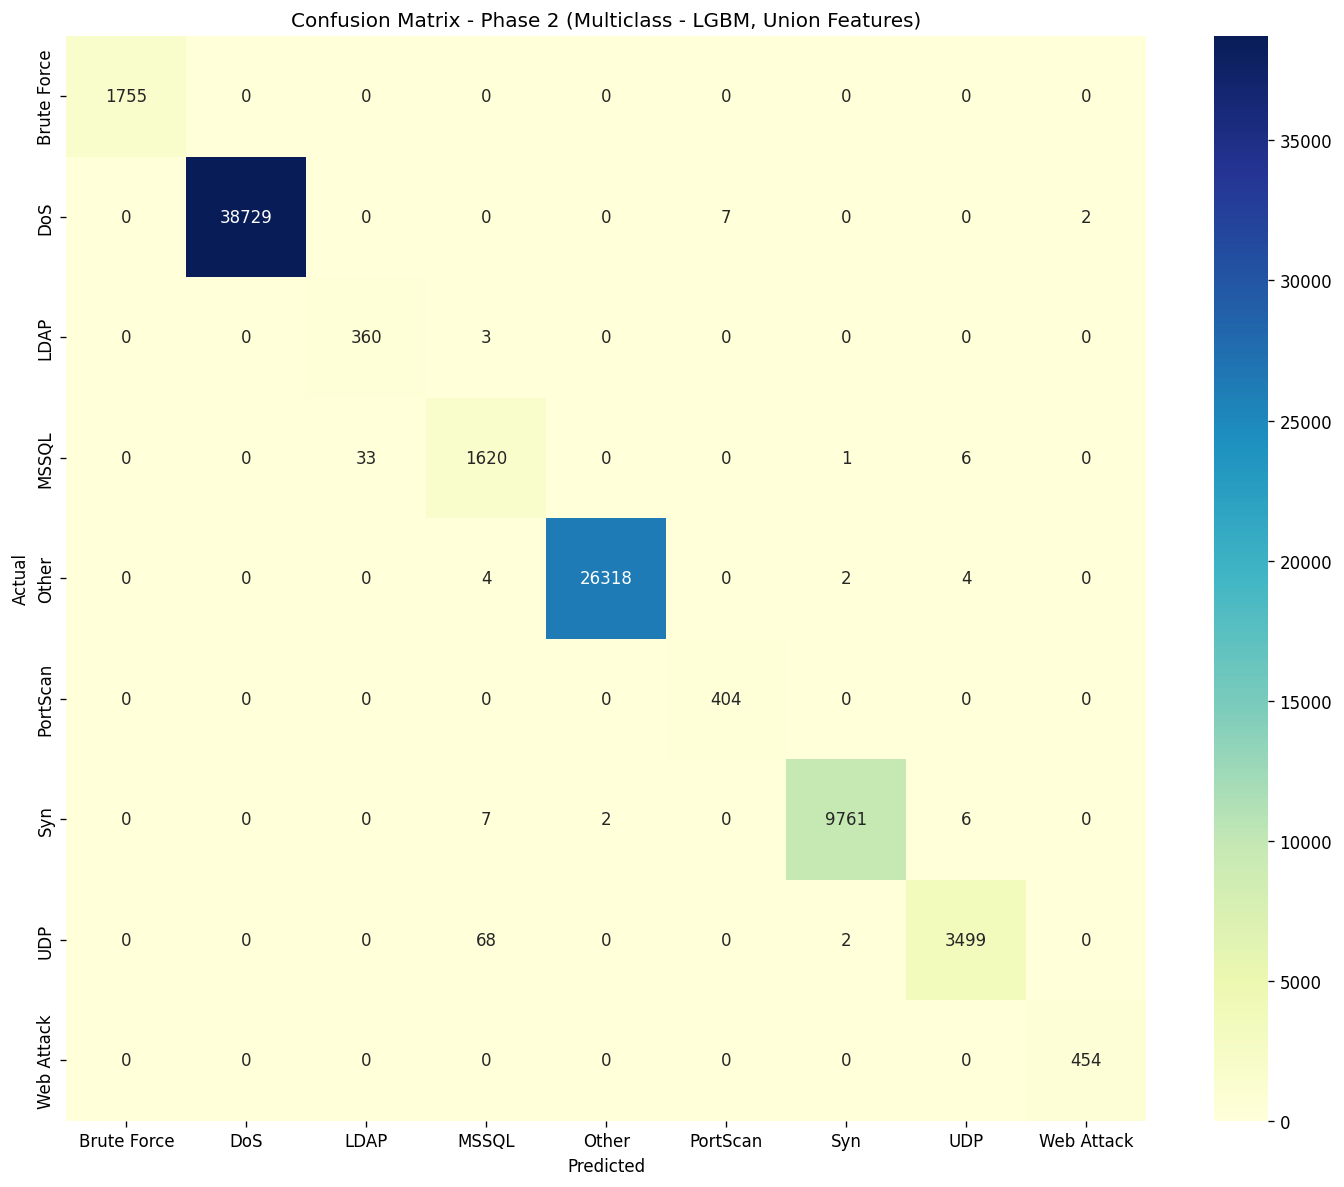

              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00      1755
         DoS       1.00      1.00      1.00     38738
        LDAP       0.92      0.99      0.95       363
       MSSQL       0.95      0.98      0.96      1660
       Other       1.00      1.00      1.00     26328
    PortScan       0.98      1.00      0.99       404
         Syn       1.00      1.00      1.00      9776
         UDP       1.00      0.98      0.99      3569
  Web Attack       1.00      1.00      1.00       454

    accuracy                           1.00     83047
   macro avg       0.98      0.99      0.99     83047
weighted avg       1.00      1.00      1.00     83047



In [18]:

# ==== PHASE 2: Multiclass trong DDoS ====
# Lấy tất cả mẫu DDoS từ df gốc, sau đó encode theo **cùng schema** đã fit ở train binary
df_attack = df[df['Label']=='DDoS'].copy()
if df_attack.empty:
    print("[WARN] Không có mẫu DDoS cho Phase 2.")
else:
    # Chuẩn bị X theo feature_candidates
    X_attack_raw = df_attack[feature_candidates].copy()

    # Encode categorical theo encoders đã học
    for c in cat_cols:
        X_attack_raw[c] = X_attack_raw[c].astype(str).fillna("")
    def map_cat_col(col, series):
        if col not in encoders:
            return series.astype('category').cat.codes.astype('int32')
        inv = encoders[col]
        return series.map(lambda v: inv.get(v, -1)).astype('int32')

    for c in cat_cols:
        X_attack_raw[c] = map_cat_col(c, X_attack_raw[c])
    for c in num_cols:
        X_attack_raw[c] = X_attack_raw[c].astype(np.float32)

    # Sắp xếp cột theo feature_order đã lưu ở phase 1
    feature_order = joblib.load('lgbm_binary_union.joblib')['feature_order']
    X_attack_enc = X_attack_raw[feature_order].values
    X_attack_s   = scaler.transform(X_attack_enc)

    y_attack = df_attack['AttackType'].astype(str).values
    from sklearn.preprocessing import LabelEncoder
    le_attack = LabelEncoder()
    y_attack_enc = le_attack.fit_transform(y_attack)
    joblib.dump(le_attack, "attack_label_encoder_union.pkl")
    n_classes = len(le_attack.classes_)
    print("Các lớp attack:", list(le_attack.classes_))

    # SMOTE cho phân lớp đa lớp
    X_attack_res, y_attack_res = SMOTE(random_state=42).fit_resample(X_attack_s, y_attack_enc)

    inv_freq = pd.Series(y_attack_res).value_counts()
    inv_ratio = inv_freq.max() / inv_freq
    sample_weight = pd.Series(y_attack_res).map(inv_ratio).values

    Xa_tr, Xa_te, ya_tr, ya_te, sw_tr, sw_te = train_test_split(
        X_attack_res, y_attack_res, sample_weight, test_size=0.2, random_state=42, stratify=y_attack_res
    )

    clf_multi = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=n_classes,
        n_estimators=1600,
        learning_rate=0.05,
        num_leaves=128,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=42
    )

    clf_multi.fit(
        Xa_tr, ya_tr,
        sample_weight=sw_tr,
        eval_set=[(Xa_te, ya_te)],
        eval_metric=['multi_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
    )

    joblib.dump({
        'model': clf_multi,
        'scaler': scaler,
        'encoders': encoders,
        'feature_order': feature_order,
        'attack_label_encoder': le_attack
    }, 'lgbm_attack_union.joblib')

    # Đánh giá trên phần test DDoS lấy từ split 8/2 toàn bộ df
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
    df_attack_test = test_df[test_df['Label']=='DDoS'].copy()
    if not df_attack_test.empty:
        X_attack_test_raw = df_attack_test[feature_candidates].copy()
        for c in cat_cols:
            X_attack_test_raw[c] = X_attack_test_raw[c].astype(str).fillna("")
            X_attack_test_raw[c] = map_cat_col(c, X_attack_test_raw[c])
        for c in num_cols:
            X_attack_test_raw[c] = X_attack_test_raw[c].astype(np.float32)
        X_attack_test = scaler.transform(X_attack_test_raw[feature_order].values)

        y_attack_test = le_attack.transform(df_attack_test['AttackType'].astype(str).values)
        y_attack_pred = clf_multi.predict(X_attack_test)

        from sklearn.metrics import confusion_matrix, classification_report
        cm2 = confusion_matrix(y_attack_test, y_attack_pred)
        labels_multi = le_attack.classes_

        plt.figure(figsize=(12,10))
        sns.heatmap(cm2, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels_multi, yticklabels=labels_multi)
        plt.title("Confusion Matrix - Phase 2 (Multiclass - LGBM, Union Features)")
        plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()

        print(classification_report(y_attack_test, y_attack_pred, target_names=labels_multi))

        rep = classification_report(y_attack_test, y_attack_pred, target_names=labels_multi, output_dict=True)
        df_report = pd.DataFrame(rep).transpose()
        df_report_main = df_report.iloc[:len(labels_multi), :4].round(2)
        df_report_main.rename(columns={'precision':'Độ chính xác','recall':'Độ bao phủ','f1-score':'F1','support':'Số mẫu'}, inplace=True)
        df_report_main.to_excel("bang_phan_loai_ddos_union.xlsx", index=True)
        with open("classification_report_union.html", "w", encoding="utf-8") as f:
            f.write(df_report_main.to_html(border=1))
    else:
        print("[WARN] Không có DDoS trong tập test để đánh giá Phase 2.")
